In [1]:
from RNNEnv import RNNClass
from tensorflow.keras.layers import SimpleRNN, LSTM
import numpy as np


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


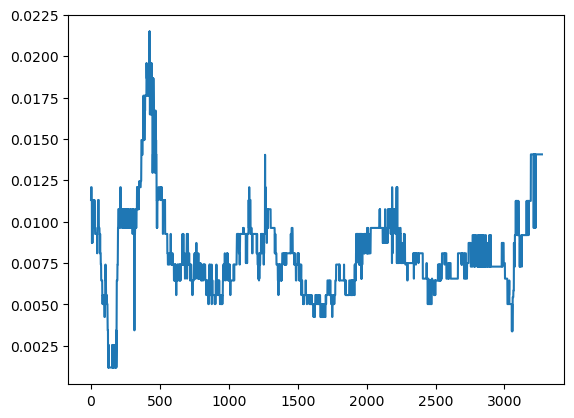

In [2]:
feature_steps = 10
target_steps = 15

ModelRNN = RNNClass(feature_steps=feature_steps,target_steps=target_steps,tickers = ['spy'],
                    layers_LSTM=0,layers_RNN=0,batchnormalization=True, epochs = 500, patience = 200,
                    learning_rate=0.00001,HuberDelta_p=1,HuberDelta_n=1)

for m in [SimpleRNN,LSTM]:
    ModelRNN.Prediction(m)

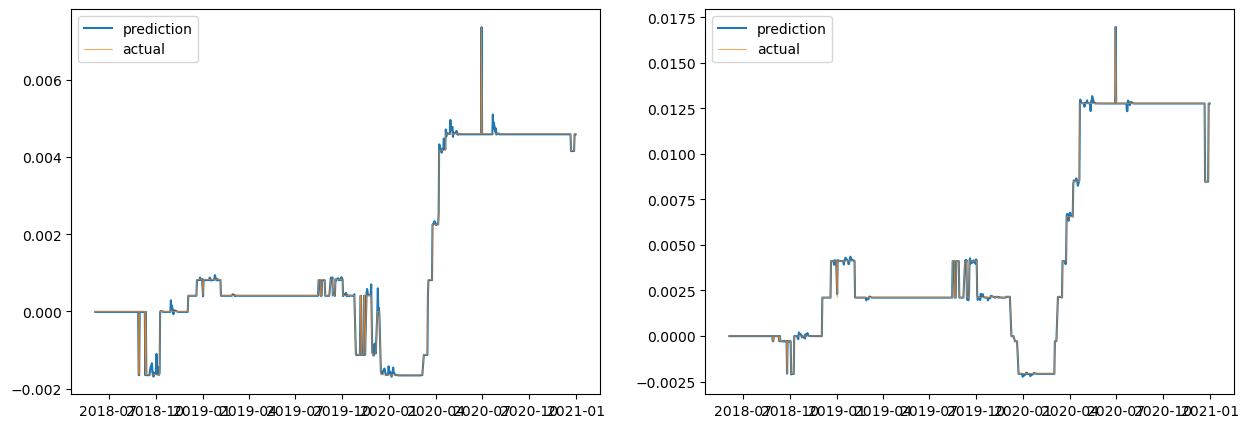

C:\Users\yoshi\AppData\Local\Temp\ipykernel_38208\1821508711.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[var].legend(loc='upper left')


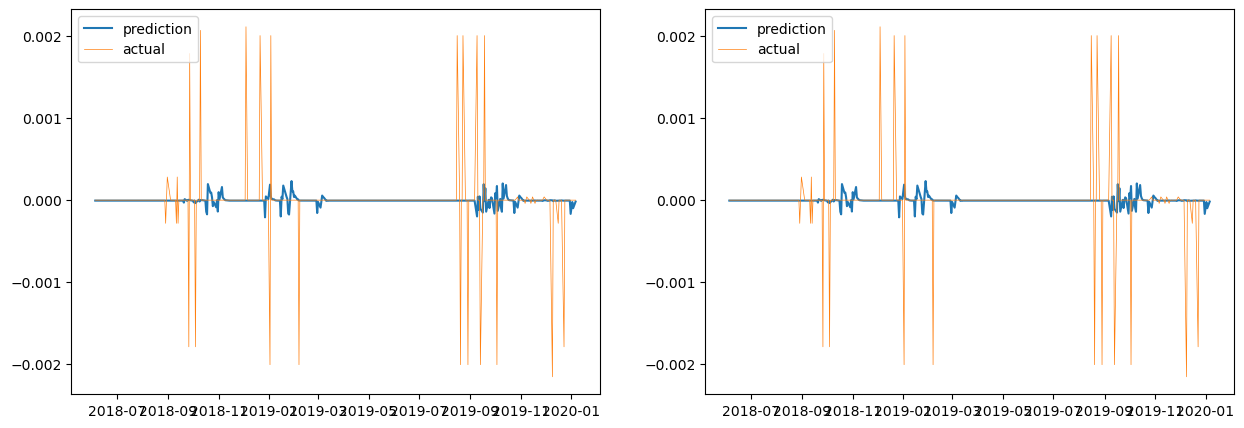

[[1.         0.99994095]
 [0.99994095 1.        ]]
[[ 1.         -0.05087202]
 [-0.05087202  1.        ]]


In [8]:
import matplotlib.pyplot as plt

T = len(ModelRNN.tickers)

mod = 0  #SimpleRNN = 0, LSTM = 1

ticker = 'spy'

fig, axes = plt.subplots(1, 2, figsize=(15, 5*T))
k = list(ModelRNN.test_pred[ticker].keys())
pred = ModelRNN.scaler[ticker].inverse_transform(ModelRNN.test_pred[ticker][k[mod]])
test = ModelRNN.scaler[ticker].inverse_transform(ModelRNN.y_test[ticker])

for var in [0,1]:
    predvar = pred[:,var]
    testvar = test[:,var]
    test_full = np.cumsum(testvar)
    pred_full = test_full+predvar
    test_full = test_full    
    axes[var].plot(ModelRNN.test_dates[ticker][k[mod]],pred_full, label = "prediction")
    axes[var].plot(ModelRNN.test_dates[ticker][k[mod]],test_full, label = "actual", linewidth=0.5)
    axes[var].legend(loc='upper left')

# Show the plot
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5*T))
for var in [0,1]:
    test_full = np.cumsum(testvar)
    pred_full = test_full+predvar
    test_full = test_full 

    axes[var].legend(loc='upper left')
    TT = 400
    axes[var].plot(ModelRNN.test_dates[ticker][k[mod]][:TT],predvar[:TT], label = "prediction")
    axes[var].plot(ModelRNN.test_dates[ticker][k[mod]][:TT],testvar[:TT], label = "actual", linewidth=0.5)
    axes[var].legend(loc='upper left')

# Show the plot
plt.show()

print(np.corrcoef(test_full,pred_full))
print(np.corrcoef(testvar,predvar))

Text(0.5, 0, 'epoch')

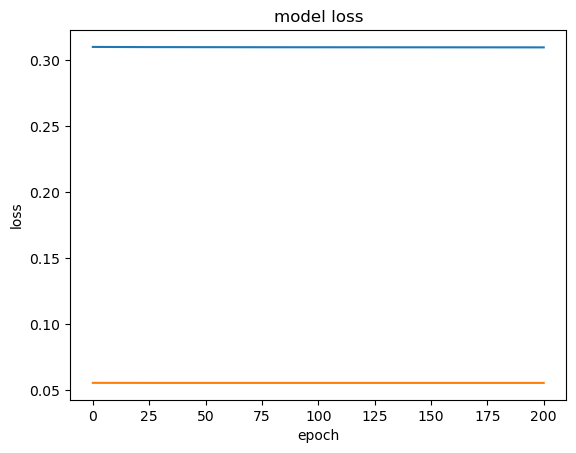

In [7]:
k = list(ModelRNN.test_pred[ticker].keys())
var = 1 #bp = 0, bn = 1

plt.plot(ModelRNN.history['spy'][k[1]][var].history['loss'])
plt.plot(ModelRNN.history['spy'][k[1]][var].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper right')

- Variation in the process $(b_p,b_n)$ over the validation set is much lower than on the  training set (which included the financial crisis), thus reducing the Huber loss over such period. 

- The gradiend is however correctly predicted most of the time over the validation set, as the next piece of code shows.

In [5]:
y = 0
N = len(pred_full)
for n in range(target_steps,N):
    if np.sign(test_full[n]-test_full[n-target_steps]) == np.sign(pred_full[n]-pred_full[n-target_steps]):
        y += 1

print(y)
print(N)
print(y/N)

449
650
0.6907692307692308
